# Analyse d'une image de microscopie à l'aide du module *scikit-image*
Ce notebook a pour objectif d'illustrer une utilisation simplifiée du module *scikit-image* pour l'analyse d'une image de cellules issue d'un microscope photonique à épifluorescence. On cherche à compter le nombre de noyaux présents sur l’image, ainsi que leur taille et leur intensité de fluorescence.

## Chargement des modules

In [1]:
# Modules de base

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Sous-modules de scikit-image pour la manipulation d'image

# lecture et écriture d'une image
import skimage.io
# ...
import skimage.exposure
# mesures sur l'image
import skimage.measure
# filtrage de l'image
import skimage.filters

# Fonction pour le téléchargement de l'image à analiser
from urllib.request import urlretrieve

# Module pour réaliser des graphiques interactifs
import plotly
import plotly.express as px
import plotly.graph_objects as go

# visualisation des graphique et des images dans le notebook
%matplotlib inline

## Téléchargement et décompréssion de l'image à analyser

In [2]:
# Téléchargement de l'image si elle n'est pas présente dans le répertoire
# courrant.
if not os.path.isfile('../img/FluorescentCells.zip'):
    print('Downloading the TIFF file for fluorescent cells image...')
    try:
        urlretrieve('https://imagej.nih.gov/ij/images/FluorescentCells.zip',
            '../img/FluorescentCells.zip')
        print("ok")
    except:
        print("Unable to download the file!")
    print('Done!')

# Décompression du fichier FluorescentCells.zip si l'image n'est pas
# décompréssée.
if not os.path.isfile("../img/FluorescentCells.tif"):
    !unzip FluorescentCells.zip

## Chargement et visualisation de l'image à analyser

L'image à analyser provient du [NIH](https://imagej.nih.gov/ij/images/FluorescentCells.zip).
L'image est chargée et stockée dans un tableau *numpy* à l'aide de la fonction `imread()` du sous-module `io` de *scikit-image*.

In [3]:
img = skimage.io.imread("../img/FluorescentCells.tif")

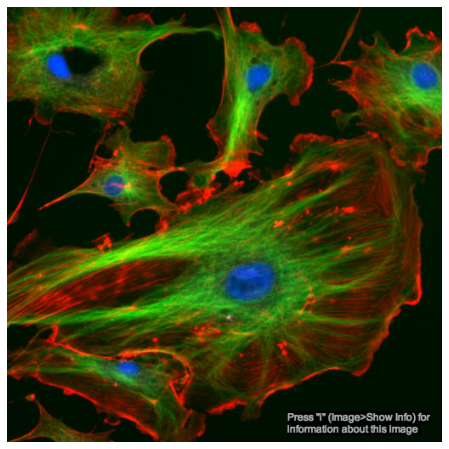

In [4]:
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis("off");

D'après la [description](https://imagej.nih.gov/ij/images/FluorescentCells.txt) de cette image, il s'agit de cellules endothéliales d'artère pulmonaire bovine obtenue par microscopie à épifluorescence. Les filaments d'actine sont marqués en rouge, les microtubules en vert, et les noyaux en bleu.

In [5]:
print(f"Dimensions de l'image : {img.shape}")
print(f"Représentation du pixel (0, 0): {img[0, 0, :]}")

Dimensions de l'image : (512, 512, 3)
Représentation du pixel (0, 0): [16 50  0]


L'image est tridimensionnelle. Les deux premières dimensions correspondent aux coordonnées (ligne, colonne) des pixels de l'image. La dernière dimensions correspondant aux différents canaux. C'est une image RGB ; le pixel (0, 0) a pour valeur 16 dans le canal rouge, 50 dans le canal vert, et 0 dans le canal bleu.

## Sélection du canal d'intérêt
Le canal d'intérêt est le canal bleu, puisque que les noyaux sont marqués au DAPI. Il faut dont utiliser l'indice `2` dans la troisième dimension de le tableau *numpy* pour le sélectionner (`1` est le canal rouge et `3` le canal vert).

In [6]:
canal_bleu = img[:, :, 2]

### Affichage du canal d'intérêt

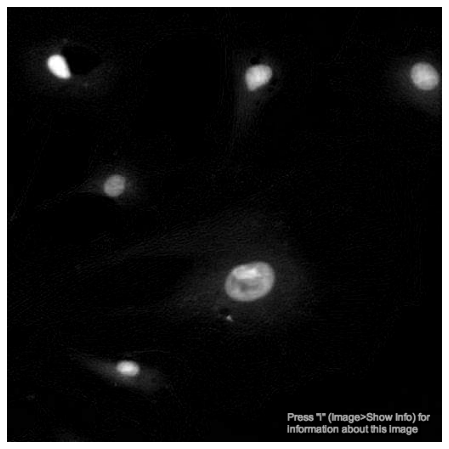

In [7]:
plt.figure(figsize=(8, 8))
plt.imshow(canal_bleu, cmap="gray")
plt.axis("off");

La sélection effectuée permet d'identifier les noyaux.

## Segmentation des noyaux

Pour sélectionner les noyaux et éliminer le bruit présent sur cette image, nous allons ici utiliser un seuil d'intensité. 

### Estimation du seuil

Pour identifier ce seuil, nous réalisons un histogramme en utilsant la fonction `histogram` du sous-module `exposure` de *scikit-image*. Cette fonction renvoie les valeurs nécessaires à la construction de l'histogramme.

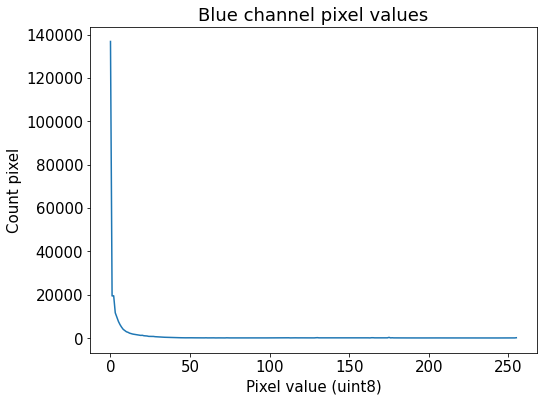

In [8]:
count, pixel_value = skimage.exposure.histogram(canal_bleu)
plt.figure(figsize=(8, 6))
plt.rc("font", size=15)
plt.plot(pixel_value, count)
plt.title("Blue channel pixel values")
plt.xlabel(f"Pixel value ({canal_bleu.dtype})")
plt.ylabel("Count pixel");

La plupart des valeurs de pixel étant nulles (aucune intensité dans le canal bleu), nous fixons une valeur limite sur l'axe des abscisses (ici, 100) pour distinguer les comptes de pixel sur l'ensemble de l'histogramme.

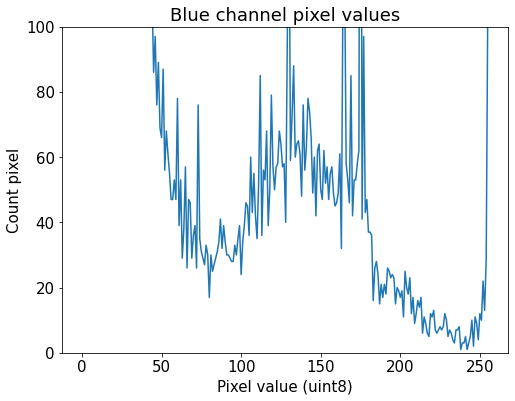

In [9]:
plt.figure(figsize=(8, 6))
plt.rc("font", size=15)
plt.plot(pixel_value, count)
plt.ylim(0, 100)
plt.title("Blue channel pixel values")
plt.xlabel(f"Pixel value ({canal_bleu.dtype})")
plt.ylabel("Count pixel");

On remarque un minimum local proche de 80 pour la valeur des pixels.

### Segmentation

Nous choisissons donc un seuil de 80 pour la sélection des noyaux.

In [10]:
seuil = 80
nuclei_mask = canal_bleu > seuil

print(f"{nuclei_mask.dtype}: {np.unique(nuclei_mask)}")

bool: [False  True]


le tableau *numpy* `nuclei_mask` ainsi créé est en fait un masque booléen. Nous pouvons l'afficher afin de voir les objets segmentés.

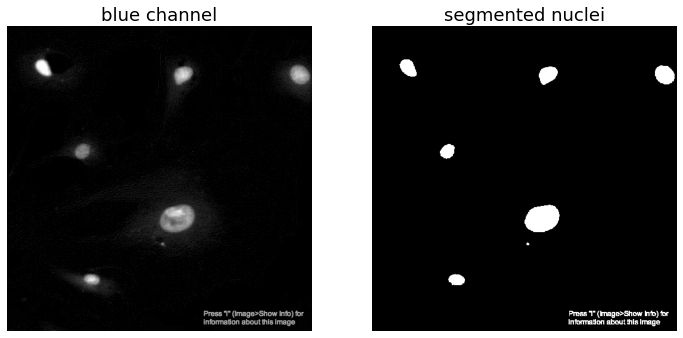

In [11]:
# create subplots to display all images in a single figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 21))

# make the array of axes 1-dimensional
axes = axes.ravel()

# turn off axis lines and labels
for ax in axes:
    ax.axis("off")

axes[0].imshow(canal_bleu, cmap="gray")
axes[0].set_title("blue channel")

axes[1].imshow(nuclei_mask, cmap="gray")
axes[1].set_title("segmented nuclei");

Nous constatons que la segmentation a plutôt bien fonctionné : tous les noyaux ont été segmentés. Toutefois, un petit groupe de pixels n'appartenant à aucun noyau se retrouve également segmenté. Pour éviter cet artefact, nous allons réaliser un filtrage de l'image.

### Filtrage de l'image

**TO DELETE** Afin de pouvoir pousuivre l'analyse de cette image, nous devons retirer la zone de texte qui pourrait biaiser le résultat.

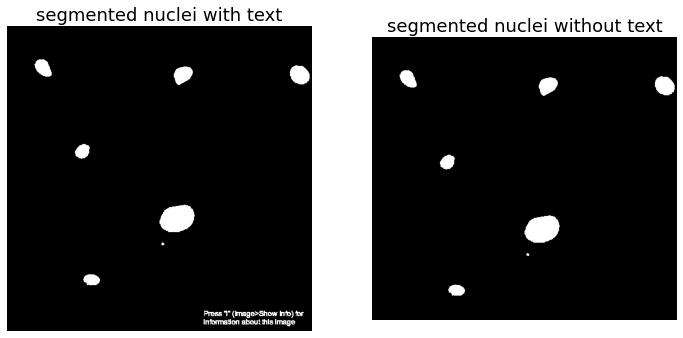

In [12]:
# create subplots to display all images in a single figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 21))

# make the array of axes 1-dimensional
axes = axes.ravel()

# turn off axis lines and labels
for ax in axes:
    ax.axis("off")

axes[0].imshow(nuclei_mask, cmap="gray")
axes[0].set_title("segmented nuclei with text")

axes[1].imshow(nuclei_mask[:476, :], cmap = "gray")
axes[1].set_title("segmented nuclei without text");

**TO DELETE** Par la sélection des lignes 0 à 475, on remarque que cela a pu retirer la zone de texte sans perte d'informations pour la suite de notre analyse.

In [13]:
nuclei_mask = nuclei_mask[:476, :]
canal_bleu = canal_bleu[:476, :]

### Etiquetage et comptage des noyaux

La fonction `label` du sous-module `measure` de *scikit-image* permet d'étiqueter chaque région contiguë de pixels de même valeur d'un tableau d'entiers. Nous l'utilisons ici sur pour donner un *label* à chaque région. En plus, elle retourne aussi le nombre de régions présentes dans le tableau *numpy* avec l'argument `return_num=True`.

In [14]:
# set return_num to True to return the number of labeled regions as well
# background=0 is used to consider 0-valued pixels as background altough also a connected region
nuclei_lab, nuclei_num = skimage.measure.label(nuclei_mask, background=0, return_num=True)

print(f"Number of segmented objects: {nuclei_num}")

Number of segmented objects: 7


Au total, 7 régions ont été segmentées.

(476, 512)
[0 1 2 3 4 5 6 7]


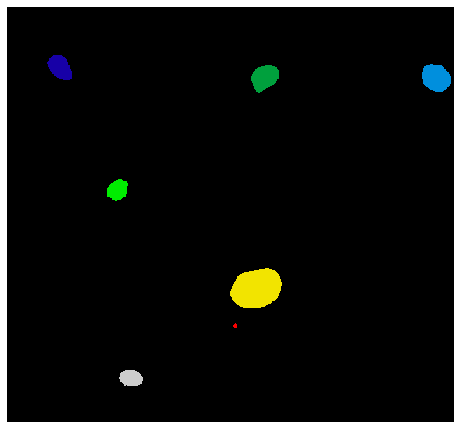

In [15]:
print(nuclei_lab.shape)
print(np.unique(nuclei_lab))
plt.figure(figsize=(8, 8))
plt.imshow(nuclei_lab, cmap="nipy_spectral", interpolation='none')
plt.axis("off");

le tableau numpy étiqueté (`nuclei_lab`) est de mêmes dimensions que le tableau d'origine (`true_nuclei`), mais il comporte 8 valeurs distinctes : une valeur pour les pixels du background, et 7 autres valeurs (de 1 à 7) pour les 7 régions segmentées, comme on le constate en affichant l'image étiquetée en couleurs.

Pour retirer l'artefact, nous allons mesurer l'aire des objets et éliminer celui ayant une aire trop petite.

### Calcul de l'aire des objets

Nous allons mesurer l'aire des noyaux. Pour cela, nous commençons par créer un masque booléen pour chacun des 7 objets segmentés auparavant.

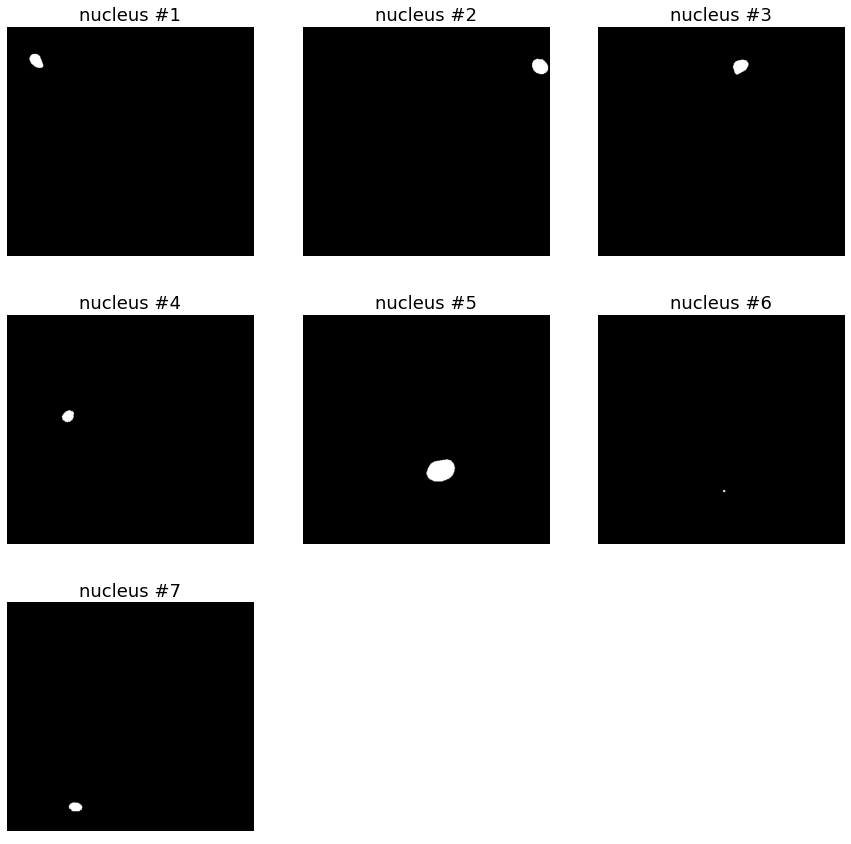

In [16]:
# list to store numpy arrays of each nucleus boolean mask
nuclei_obj = []

# create each nucleus boolean mask using its label and append it to nuclei_obj
for i in range(nuclei_num):
    nuc = (nuclei_lab == i + 1)
    nuclei_obj.append(nuc)

    
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

# make the array of axes 1-dimensional
axes = axes.ravel()

# turn off axis lines and labels
for ax in axes:
    ax.axis("off")

for i, nuc in enumerate(nuclei_obj):
    axes[i].imshow(nuc, cmap="gray")
    axes[i].set_title("nucleus #" + str(i + 1))

Les arrays *numpy* ainsi créés sont effectivement les masques booléens de chacun des 7 objets.

Pour mesurer l'aire de chaque noyau, nous comptons le nombre de pixel présent dans chaque région. Les pixels étiquetés ayant pour  valeur `True` et les autres pixels `False`, il suffit de faire la somme des éléments de chaque masque booléen pour obtenir l'aire (en pixel) de chaque noyau.

In [17]:
# measure nuclei areas

# create empty list to  store areas
nuc_areas = []

# measure each nucleus area and append it to nuc_areas
for i in range(nuclei_num):
    area = np.sum(nuclei_obj[i])
    nuc_areas.append(area)
    print(f"nuc_{i + 1} area: {nuc_areas[i]} pixels")

nuc_1 area: 593 pixels
nuc_2 area: 824 pixels
nuc_3 area: 705 pixels
nuc_4 area: 454 pixels
nuc_5 area: 2097 pixels
nuc_6 area: 18 pixels
nuc_7 area: 406 pixels


On remarque que l'objet `nuc_6` a une aire de 18 pixels, une valeur trop faible pour concidérer cet objet comme un noyau. Nous allons donc sélectionner les noyaux.

### Sélection des noyaux

Afin de réaliser cette sélection, nous allons créer un array *numpy* qui contiendra les noyaux dont l'aire est supérieure ou égale au seuil fixé de 50 pixels.

Number of nuclei: 6


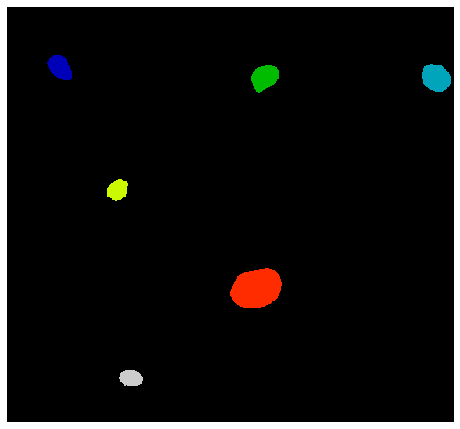

In [19]:
threshold_area = 50
# Make an empty image the same size as our orignal binary image
approved_nuclei = np.zeros_like(nuclei_mask)

# Loop through each object and test its area.
for i in range(nuclei_num):
    # Get the cell of interest.
    nuclei = (nuclei_lab == i + 1)
    
    # Compute its area. 
    cell_area = np.sum(nuclei)
    
    # Test if it is within our bounds. 
    if (cell_area > threshold_area):
        
        # Add our extraced cell to our blank image.
        approved_nuclei += nuclei

# Relabel and show the approved_cells mask
approved_lab, num_obj = skimage.measure.label(approved_nuclei, return_num=True)

print(f"Number of nuclei: {num_obj}")
plt.figure(figsize=(8, 8))
plt.imshow(approved_lab, cmap="nipy_spectral", interpolation='none')
plt.axis("off");

On remarque que l'artefact n'est plus considéré comme étant un noyau. On compte bien 6 noyaux.

## Alternative : segmentation après filtrage de l'image

Il existe une seconde manière de réaliser le filtrage de l'image, en utilisant un filtre gaussien.

Le filtre gaussien permet de réduire le bruit en lissant l'image par une méthode de "convolution". Cette méthode revient à calculer une nouvelle valeur pour chaque pixel en faisant la moyenne de ce pixel et des pixels l'entourant, le poids relatif de chaque pixel étant déterminé par les valeurs contenues dans un kernel. On dit qu'on effectue une convolution de l'image avec un kernel.

L'image filtrée `fluocells_b_filtered` est obtenue en appliquant sur le canal bleu (`fluocells_b`) la fonction `gaussian()` du sous-module `filters` de *scikit-image*.

In [20]:
fluocells_b_filtered = skimage.filters.gaussian(canal_bleu,
                                                sigma=2,
                                                preserve_range=True)

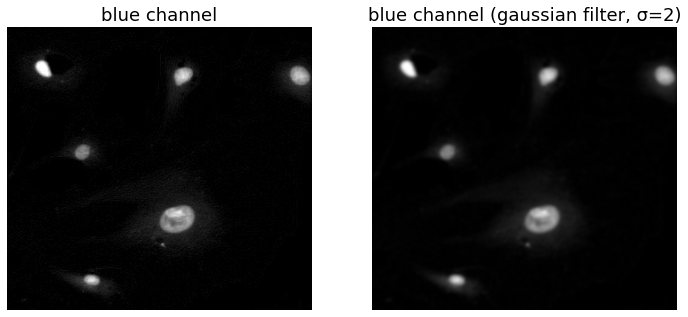

In [21]:
# create subplots to display all images in a single figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 21))

# make the array of axes 1-dimensional
axes = axes.ravel()

# turn off axis lines and labels
for ax in axes:
    ax.axis("off")

axes[0].imshow(canal_bleu, cmap="gray")
axes[0].set_title("blue channel")

axes[1].imshow(fluocells_b_filtered, cmap="gray")
axes[1].set_title("blue channel (gaussian filter, σ=2)");

L'artefact étant directement entouré de pixels ayant des valeurs faibles du fait de sa petite aire, on s'attend à ce que le filtrage réduise davantage son intensité que celle des objets identifiés comme des noyaux, qui on une aire plus importante.

### Segmentation (après filtrage par le filtre gaussien)

La segmentation est cette fois réalisée sur l'image filtrée par le filtre gaussien.

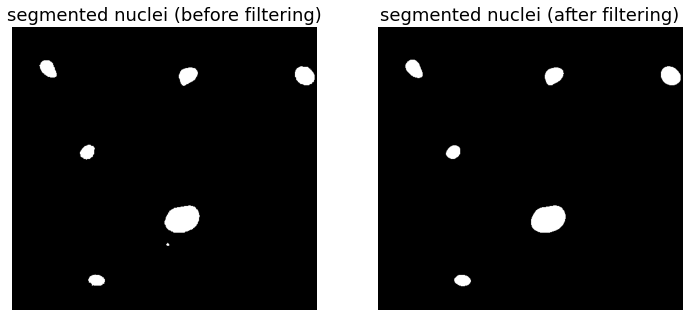

In [23]:
threshold = 80
true_nuclei = (fluocells_b_filtered > threshold)
true_nuclei = true_nuclei.astype(int)

# create subplots to display all images in a single figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 21))

# make the array of axes 1-dimensional
axes = axes.ravel()

# turn off axis lines and labels
for ax in axes:
    ax.axis("off")

axes[0].imshow(nuclei_mask, cmap="gray")
axes[0].set_title("segmented nuclei (before filtering)")

axes[1].imshow(true_nuclei, cmap="gray")
axes[1].set_title("segmented nuclei (after filtering)");

On remarque que l'utilisation du filtre gaussien permet de supprimer l'artefact durant la segmentation. Néanmoins, nous n'utiliseront pas cette méthode de filtrage de l'image pusiqu'elle induit une modification de cette dernière. En effet, comme expliqué plus haut, l'utilisation du filtre gaussien entraine une modification de l'image (un lissage). On a donc, une perte d'information de l'image, ce que l'on ne souhaite pas dans notre cas, puisque l'on veux réaliser diverses mesures sur les objets segmenté (sélection) tel qu'une mesure d'intensité de fluorescence.  

On utilisera preférentiellement la première méthode de filtrage de l'image.

## Mesures sur les noyaux

Nous allons effectuer des mesures (aire, intensité, périmètre) sur les noyaux. Pour cela, nous commençons par créer un masque booléen pour chacun des 6 noyaux. Ces mesures seront stockés dans un data-frame Pandas (`nuclei_measure`).

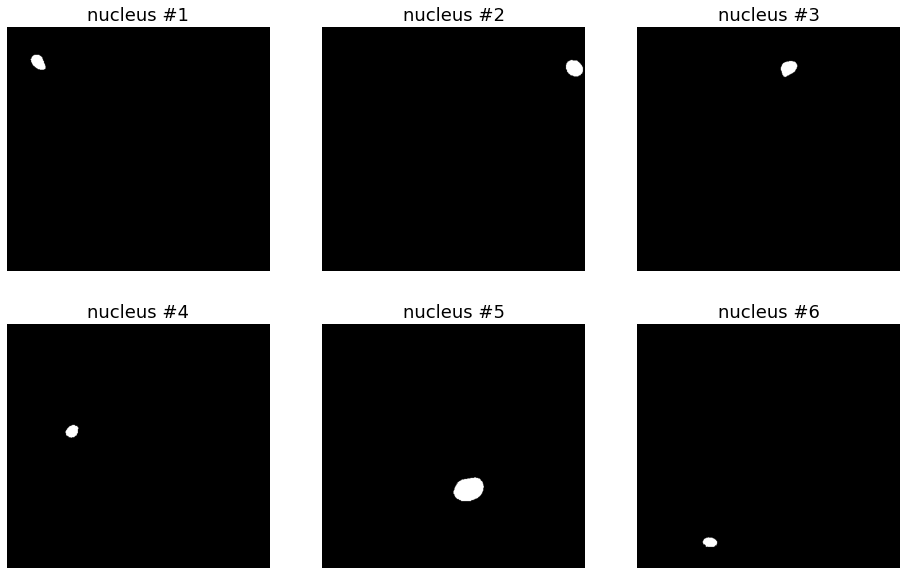

In [24]:
# list to store numpy arrays of each nucleus boolean mask
nuclei_obj = []

# create each nucleus boolean mask using its label and append it to nuclei_obj
for i in range(num_obj):
    nuc = (approved_lab == i + 1)
    nuclei_obj.append(nuc)

    
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 10))

axes = axes.ravel()

# turn off axis lines and labels
for ax in axes:
    ax.axis("off")

for i, nuc in enumerate(nuclei_obj):
    axes[i].imshow(nuc, cmap="gray")
    axes[i].set_title("nucleus #" + str(i + 1))

Les *arrays numpy* ainsi créés sont effectivement les masques booléens de chaqun des 6 noyaux.

### Mesure de l'intensité des noyaux

Pour mesurer l'aire de chaque noyau, nous comptons le nombre de pixel présent dans chaque région. Les pixels étiquetés ayant pour  valeur `True` et les autres pixels `False`, il suffit de faire la somme des éléments de chaque masque booléen pour obtenir l'aire (en pixel) de chaque noyau.  

Pour mesurer l'intensité totale de chaque noyau, nous faisons la somme des valeurs d'intensité contenues dans l'*array numpy* du canal bleu (`canal_bleu`) associées aux pixels appartenant au noyau mesuré. Chaque intensité totale est ensuite divisée par l'aire du noyau correspondant pour obtenir des intensités moyennes.

In [25]:
# measure nuclei areas

# create empty list to  store areas
nuc_areas = []

# measure each nucleus area and append it to nuc_areas
for i in range(num_obj):
    area = np.sum(nuclei_obj[i])
    nuc_areas.append(area)

# nuclei mean intensities

# create empty list to store mean intensities
nuc_intensities = []

# measure each nucleus intensity and append it to nuc_intensities
for i in range(num_obj):
    intensity = np.sum(nuclei_obj[i] * canal_bleu) / nuc_areas[i]
    nuc_intensities.append(intensity)


for i in range(num_obj): 
    print(f"nuclei {i + 1} :  mean intensity = {nuc_intensities[i]:.1f}"
          f" per pixel ; area =  {nuc_areas[i]} pixels")

nuclei 1 :  mean intensity = 202.6 per pixel ; area =  593 pixels
nuclei 2 :  mean intensity = 144.6 per pixel ; area =  824 pixels
nuclei 3 :  mean intensity = 156.3 per pixel ; area =  705 pixels
nuclei 4 :  mean intensity = 113.4 per pixel ; area =  454 pixels
nuclei 5 :  mean intensity = 140.0 per pixel ; area =  2097 pixels
nuclei 6 :  mean intensity = 151.2 per pixel ; area =  406 pixels


La taille d'un pixel n'étant pas connue, ces mesures ne peuvent pas être exprimées avec les unités du système métrique. 

Il existe également une fonction du sous module `measure` de *scikit-image* qui permet de réaliser différentes mesures sur notre image en un seul appel de fonction. Nous nous intéresseront plus particulièrement à l'aire, l'intensité moyenne et le périmètre des noyaux que l'on a segmenté auparavent. Toute ces mesures seront stocké dans un data-frame Pandas que l'on nomera `measure_nuclei` et que l'on sauvegardera dans un fichier CSV, nommé `measure_nuclei.csv`

---------------------------

Heureusement, ces mesures peuvent également être effectuées à l'aide du module *scikit-image*. La fonction `regionprops` du sous-module `measure` de *scikit-image* décrit un certain nombre de propriétés associées à chaque région étiquetée, dont l'aire et l'intensité moyenne. Ces propriétés sont accessibles *via* les attributs associés à l'objet renvoyé par la fonction (ici, `.area` pour l'aire, et `mean_intensity` pour l'intensité moyenne).

In [40]:
nuclei_props = skimage.measure.regionprops(approved_lab,
                                           intensity_image=canal_bleu)

measure_nuclei = pd.DataFrame(
    {"area" : [nuclei_props[i].area for i
               in range(len(nuclei_props))],
     
     "mean_intensity" : [nuclei_props[i].mean_intensity for i
                         in range(len(nuclei_props))],
     
     "perimeter" : [nuclei_props[i].perimeter for i
                    in range(len(nuclei_props))],
     
     "eccentricity" : [nuclei_props[i].eccentricity for i
                      in range(len(nuclei_props))]
    }
)

measure_nuclei.to_csv("measure_nuclei.csv", sep = ";")

In [41]:
print(measure_nuclei)

   area  mean_intensity   perimeter  eccentricity
0   593      202.618887   93.840620      0.760119
1   824      144.628641  107.254834      0.555364
2   705      156.302128  102.083261      0.665195
3   454      113.394273   80.183766      0.582738
4  2097      139.996662  175.539105      0.686000
5   406      151.201970   79.112698      0.745340


La distribution de l'aire des noyaux peut être visualisée sous forme d'histogramme.

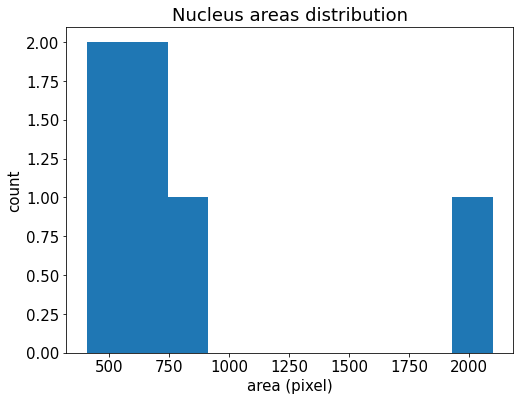

In [31]:
plt.figure(figsize=(8, 6))
plt.rc("font", size=15)
plt.hist(measure_nuclei["area"], bins=10)
plt.title("Nucleus areas distribution")
plt.xlabel("area (pixel)")
plt.ylabel("count");

### Intensité moyenne des noyaux

La distribution de l'intensité moyenne des noyaux peut être visualisée sous forme d'histogramme.

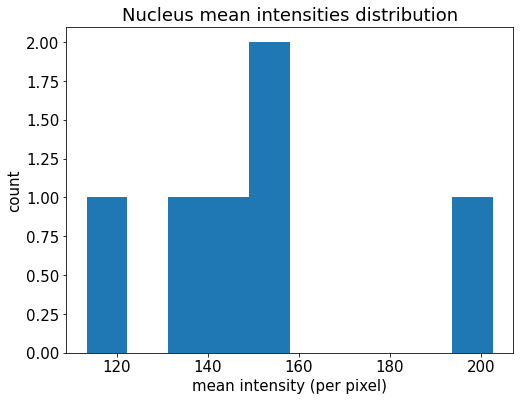

In [32]:
plt.figure(figsize=(8, 6))
plt.rc("font", size=15)
plt.hist(measure_nuclei["mean_intensity"], bins=10)
plt.title("Nucleus mean intensities distribution")
plt.xlabel("mean intensity (per pixel)")
plt.ylabel("count");

Nous pouvons aussi représenter l'aire et l'intensité moyenne de chaque noyau sur le même graphique en traçant un nuage de points.

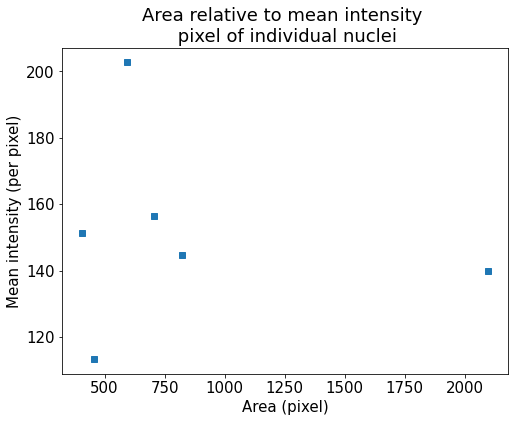

In [34]:
plt.figure(figsize=(8, 6))
plt.rc("font", size=15)
plt.plot(measure_nuclei["area"], measure_nuclei["mean_intensity"], "s")
plt.title("Area relative to mean intensity \n pixel of individual nuclei")
plt.xlabel("Area (pixel)")
plt.ylabel("Mean intensity (per pixel)");

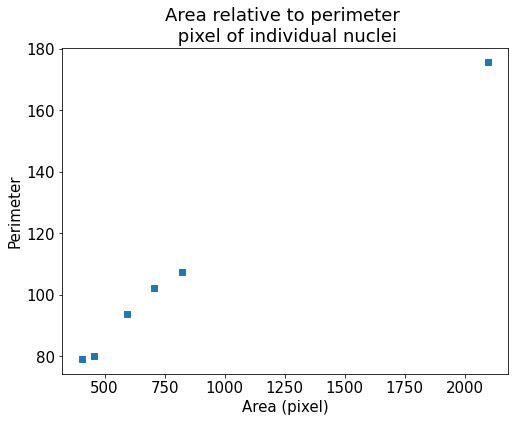

In [35]:
plt.figure(figsize=(8, 6))
plt.rc("font", size=15)
plt.plot(measure_nuclei["area"], measure_nuclei["perimeter"], "s")
plt.title("Area relative to perimeter \n pixel of individual nuclei")
plt.xlabel("Area (pixel)")
plt.ylabel("Perimeter");

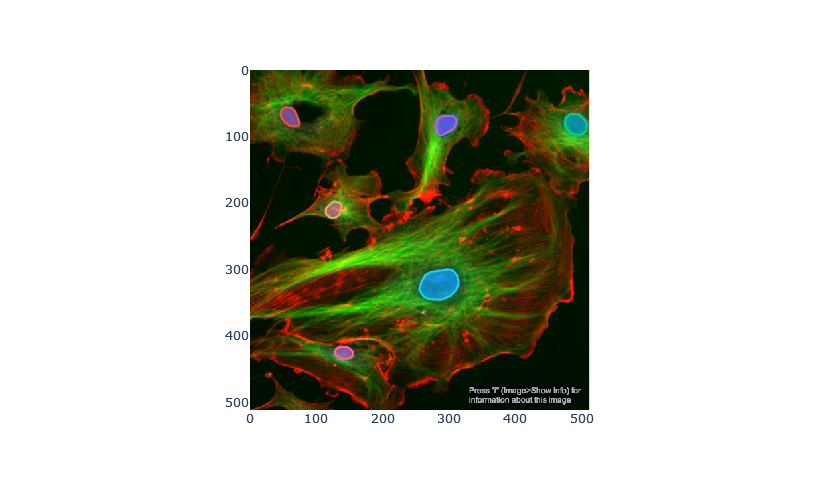

In [39]:
fig = px.imshow(img)
fig.update_traces(hoverinfo='skip') # hover is only for label info
fig.update_layout(autosize=False, width=500, height=500)

properties = ['area', 'perimeter', 'mean_intensity', 'eccentricity']

# For each label, add a filled scatter trace for its contour,
# and display the properties of the label in the hover of this trace.
for index in range(0, approved_lab.max()):
    label_i = nuclei_props[index].label
    contour = skimage.measure.find_contours(approved_lab == label_i, 0.5)[0]
    y, x = contour.T
    hoverinfo = ''
    for prop_name in properties:
        hoverinfo += f'<b>{prop_name}: {getattr(nuclei_props[index], prop_name):.2f}</b><br>'
    fig.add_trace(go.Scatter(
        x=x, y=y, name=label_i,
        mode='lines', fill='toself', showlegend=False,
        hovertemplate=hoverinfo, hoveron='points+fills'))

plotly.io.show(fig)